In [0]:
%matplotlib inline
import os
from IPython.core.interactiveshell import InteractiveShell 
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import r2_score

In [0]:
InteractiveShell.ast_node_interactivity = "all"
path = "../../csv/Mercedes-Benz Greener Manufacturing/"
random_state = 11

In [0]:
def chdir_home():
  pwd = !pwd
  if pwd[0].count('/')>1 : 
    os.chdir((pwd[0].count('/')-1)*'../')

def anova(features, target, df):
    oneway_f = pd.DataFrame(index = features, columns=['f-stat','p-value'])
    for feat in tqdm(features):
        samples=[]
        for level in list(df[feat].unique()):
            samples.append(list(df.loc[df[feat]==level, [target]].values))
        f_stat, p_val = stats.f_oneway(*samples)
        oneway_f.loc[feat,:] = np.stack((f_stat, p_val)).flatten()
    return oneway_f


def feat_to_rem(train, test, columns):
    features=[]
    for col in columns : 
        level_train = list(train[col].value_counts().index)
        level_test = list(test[col].value_counts().index)
        excl_feat = [l for l in level_test if l not in level_train]
        features.extend([col+'_'+ f for f in excl_feat])
    return features

def exclusive_levels(train, test, columns):
    for col in columns:
        train_levels = list(train[col].value_counts().index)
        test_levels = list(test[col].value_counts().index)
        exc_train = [lev for lev in train_levels if lev not in test_levels]
        exc_test = [lev for lev in test_levels if lev not in train_levels]
        print ('Exclusive {0}'.format(col))
        print ('{0} levels in train and not in test : {1}'.format(len(exc_train), exc_train))
        print ('{0} levels in test and not in train : {1}'.format(len(exc_test), exc_test))

In [0]:
# for cythonix uncomment following lines
# train = pd.read_csv(path+"train.csv")
# test = pd.read_csv(path+"test.csv")


In [0]:
# for colab uncomment following lines
chdir_home()
train = pd.read_csv('drive/workspace/data/merc/train.csv')
test = pd.read_csv('drive/workspace/data/merc/test.csv')

In [9]:
train.head(10)
train.shape, test.shape
train.info()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
5,18,92.93,t,b,e,c,d,g,h,s,...,0,0,1,0,0,0,0,0,0,0
6,24,128.76,al,r,e,f,d,f,h,s,...,0,0,0,0,0,0,0,0,0,0
7,25,91.91,o,l,as,f,d,f,j,a,...,0,0,0,0,0,0,0,0,0,0
8,27,108.67,w,s,as,e,d,f,i,h,...,1,0,0,0,0,0,0,0,0,0
9,30,126.99,j,b,aq,c,d,f,a,e,...,0,0,1,0,0,0,0,0,0,0


((4209, 378), (4209, 377))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


Okay, so there are 4209 values in train and test. There are 378 columns including the target variable out of which 8 are object type, 1 is float(target variable 'y') and rest are integer. The integer features except the target variable are binary in nature taking only 2 values : 0 and 1. 

In [0]:
cat_feat = train.select_dtypes(include=['object']).columns
num_feat = train.select_dtypes(include=['int64', 'float64']).columns

cat_feat has all categorical features, while num_feat has all numerical features.

In [11]:
train.isnull().sum().sum()

0

Also we can see that there are no null values. 

Let's first see how are target variable is distributed. 

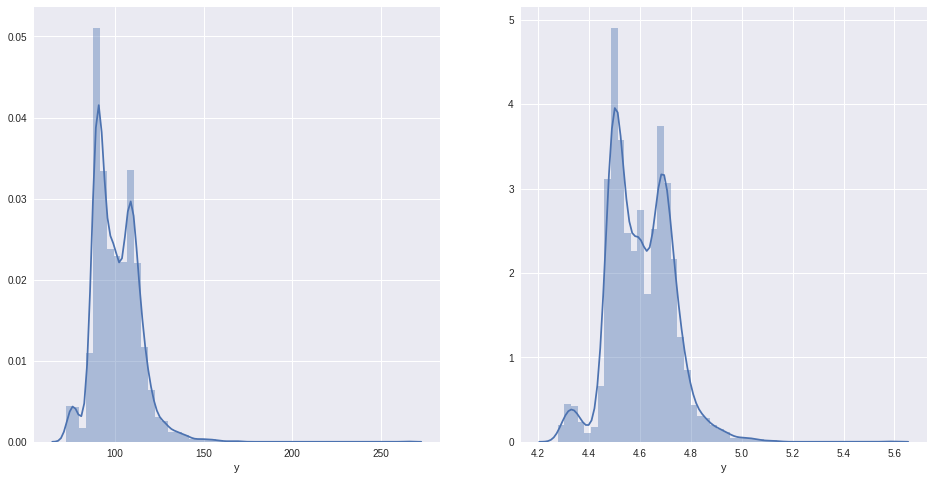

In [12]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
sns.set_style('darkgrid')
sns.distplot(train['y'], ax=ax[0])
sns.distplot(np.log(train['y']), ax=ax[1])

In [13]:
train['y'].describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

So the target variable 'y'(time in seconds a car took to pass testing) caries from 72.11 to 265.32 with a mean of 100.67 and standard deviation of 12.68 . Also the first plot shows that it is positively skewed and has high kurtosis. 
Since most of the statistical tests require the variable to be normally distributed, lets use log transformation on 'y' to bring it closer to normal. 

Before Transformation : 
Skewness : 1.2060958289669412
Kurtosis : 7.899893252938124

After Transformation : 
Skewness : 0.38984118039470267
Kurtosis : 1.3065600357272684


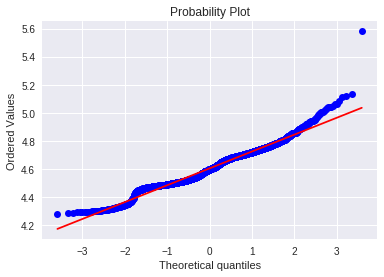

In [14]:
print ("Before Transformation : ")
print ("Skewness : {0}".format(stats.skew((train['y']))))
print ("Kurtosis : {0}".format(stats.kurtosis(train['y'])))

train['logy'] = np.log(train['y'])

print ("\nAfter Transformation : ")
print ("Skewness : {0}".format(stats.skew((train['logy']))))
print ("Kurtosis : {0}".format(stats.kurtosis(train['logy'])))

_, ax = plt.subplots()
prob = stats.probplot(train['logy'], plot=ax)

After transformation we see that the skewness and kurtosis are within acceptable range ie between +2 to -2. 

Now we will analyse our categorical variables.

## Categorical Varibles

In [15]:
train[cat_feat].describe()

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,w,g,j
freq,360,833,1659,1942,4205,231,1042,277


Lets individually check X3, X4 as they have relatively few levels. 
#### X3

In [16]:
train['X3'].value_counts()
train['X3'].head(20)

c    1942
f    1076
a     440
d     290
g     241
e     163
b      57
Name: X3, dtype: int64

0     a
1     e
2     c
3     f
4     f
5     c
6     f
7     f
8     e
9     c
10    f
11    f
12    c
13    f
14    e
15    f
16    f
17    c
18    c
19    f
Name: X3, dtype: object

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


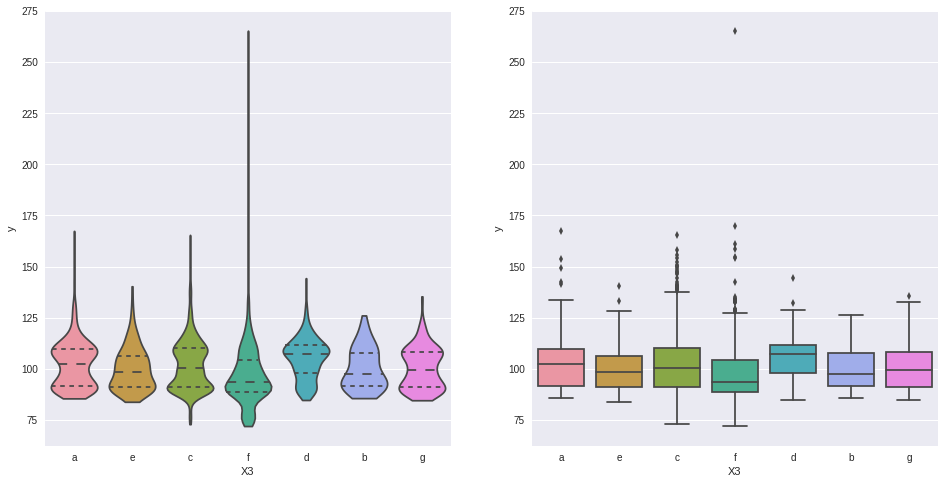

In [17]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.violinplot(x='X3', y='y', data=train, cut=0, inner='quartile', ax=ax[0], scale='width')
sns.boxplot(x='X3', y='y', data=train, ax=ax[1])

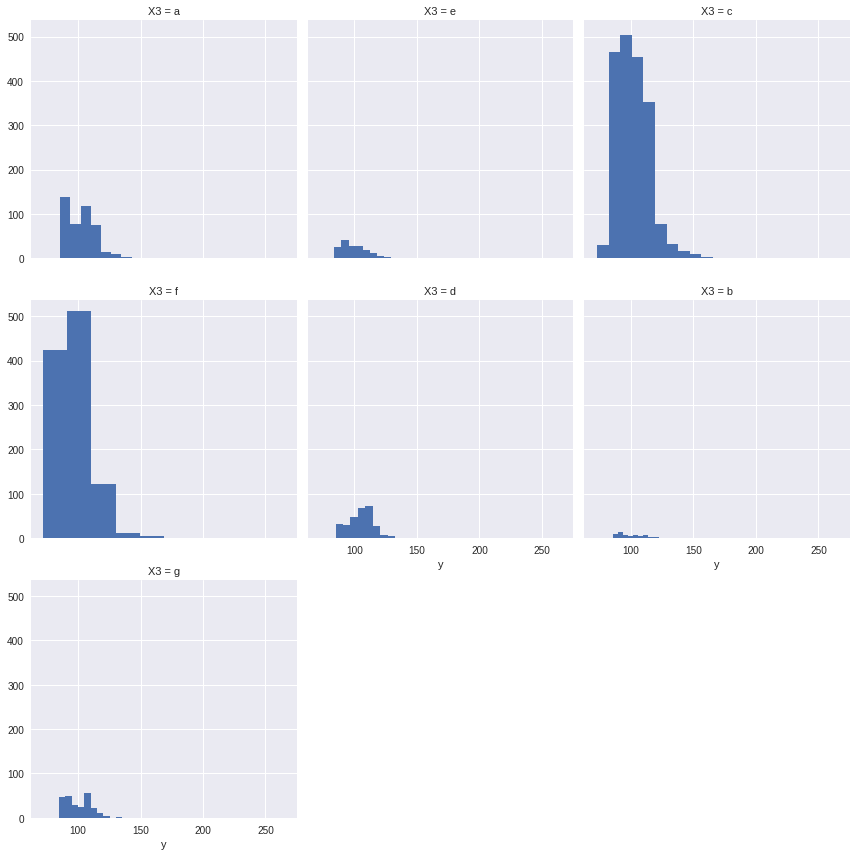

In [18]:
g = sns.FacetGrid(train, col_wrap=3, size=4, aspect=1, col='X3')
g = g.map(plt.hist, 'y')

Above 2 plots show quite a contrast in our target feature 'y' amongst various levels of X3. Target feature 'y' has a distinguishably different mean and distributions for levels c, f, d, b. So this feature X3 seems important but lets try to quantify our findings by runnings an ANOVA and see whether these changes in y are by chance or X3 is statiscally important. 

In [19]:
anova(['X3'], 'logy', train)

100%|██████████| 1/1 [00:00<00:00, 20.86it/s]


,f-stat,p-value
X3,37.5434,1.30815e-44


With a high F-statistic and low p-value we can say that the differences in mean in target feature y/logy aren't by chance but due to X3. But to find out whether all levels make a significant difference we need to one-hot encode our variables and then conduct a t-test and find a p-value for each dummy variable. 
Let's try a similar analysis for X4 and X6

### X4


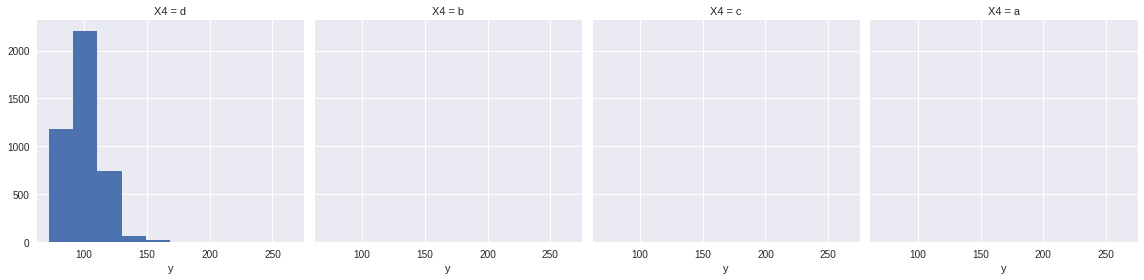

In [20]:
g = sns.FacetGrid(col='X4', data=train, col_wrap=4, size=4, aspect=1)
g = g.map(plt.hist, 'y')


In [21]:
train['X4'].value_counts()

d    4205
a       2
b       1
c       1
Name: X4, dtype: int64

As we see most of the values in X4 belong to level 'd' and thus this feature could be dropped for being a near zero variance predictor. 

### X6

In [22]:
train['X6'].value_counts()

g    1042
j    1039
d     625
i     488
l     478
a     206
h     190
k      43
c      38
b      28
f      20
e      12
Name: X6, dtype: int64

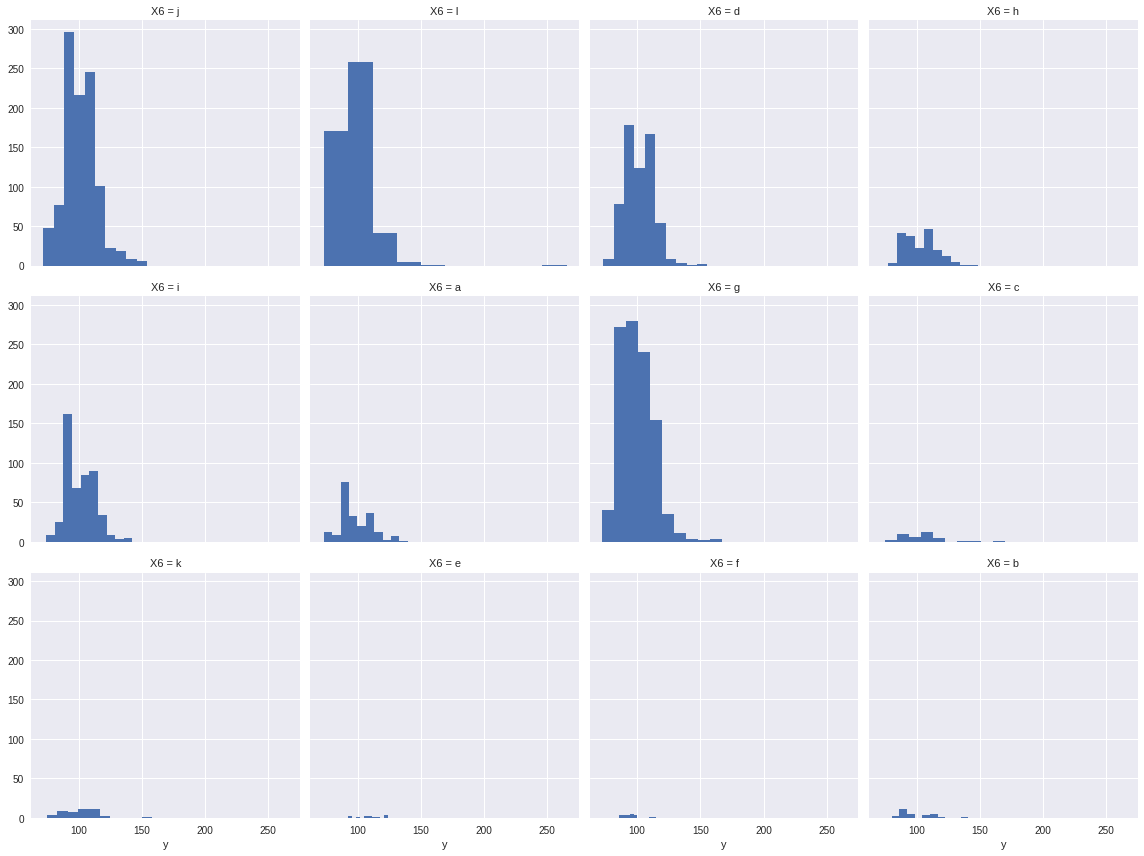

In [23]:
g = sns.FacetGrid(data=train, col='X6', size=4, aspect=1, col_wrap=4)
g.map(plt.hist, 'y')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


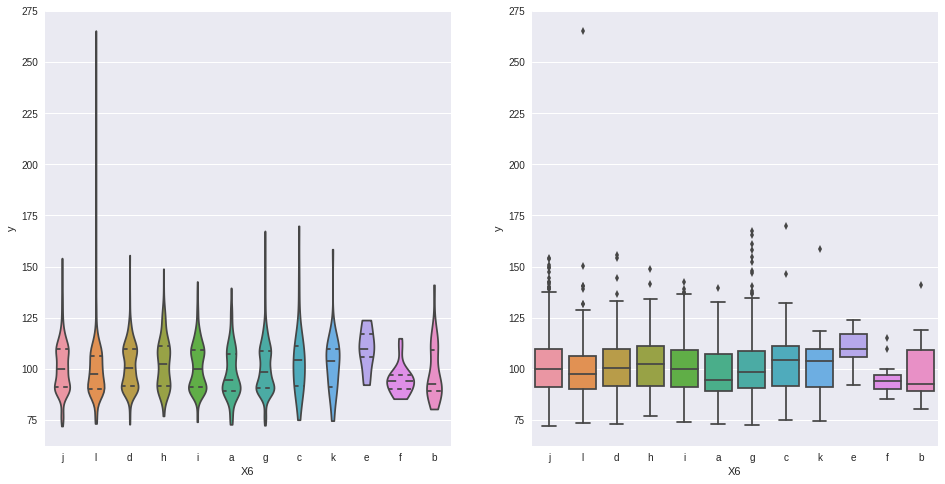

In [24]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
sns.violinplot(x='X6', y='y', data=train, ax=ax[0], cut=0, inner='quartile')
sns.boxplot(x='X6', y='y', data=train, ax=ax[1])

The plots show that the categories make a difference in the target feature. Let's verify this statistically. 

In [25]:
anova(['X6'], 'logy', train)

100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


,f-stat,p-value
X6,4.53131,7.37401e-07


Yup, X6 is also statiscally significant. So lets check p-value for each of the categorical features. 

In [26]:
anova(cat_feat, 'logy', train)

100%|██████████| 8/8 [00:00<00:00, 12.89it/s]


,f-stat,p-value
X0,156.423,0
X1,8.25031,1.16538e-30
X2,33.0128,3.94362e-229
X3,37.5434,1.30815e-44
X4,2.284,0.0769297
X5,2.13207,0.000477215
X6,4.53131,7.37401e-07
X8,5.60663,4.84094e-17


The features are statistically significant except for X4. And as we saw X4 is a near 0 variance predictorand so it is better to not include it in modelling. 

Let's now analyse our binary features. 
## Binary features

In [27]:
train1 = train.T.drop_duplicates().T
rem_feat = [f for f in list(train.columns) if f not in list(train1.columns)]
len(rem_feat)

# The above operation changes the data type of numeric features to 'object' so let's change them back. 
train1['y'] = pd.to_numeric(train1['y'])
train1['ID'] = pd.to_numeric(train['ID'])
train1['logy'] = pd.to_numeric(train['logy'])

56

This removes 56 duplicate features from train dataframe. `rem_feat` contains features that were removed. Let's also remove them from `test`. 

In [0]:
test1 = test.drop(rem_feat, axis=1)

In [29]:
var_df = pd.DataFrame(columns=['feature', 'variance'])
for feat in list(set(train1.columns)-set(cat_feat)) : 
    var_df.loc[var_df.shape[0],:] = list((feat, train1[feat].var()))
var_df = var_df.sort_values(by='variance', axis=0)
var_df

,feature,variance
232,X11,0
132,X257,0.000237586
138,X207,0.000237586
213,X339,0.000237586
110,X33,0.000237586
22,X259,0.000237586
303,X210,0.000237586
181,X280,0.000237586
183,X95,0.000237586
50,X190,0.000237586


There is one feature X11 which has 0 variance and many number of features that have near 0 variance. We can comfortably drop X11 but for other near-zero variance features I am not that comfortable to simply drop them without analysing further. So first let's drop X11. 

In [0]:
train1 = train1.drop('X11', axis=1)
test1 = test1.drop('X11', axis=1)

Now let's see how is our train-test data split. 

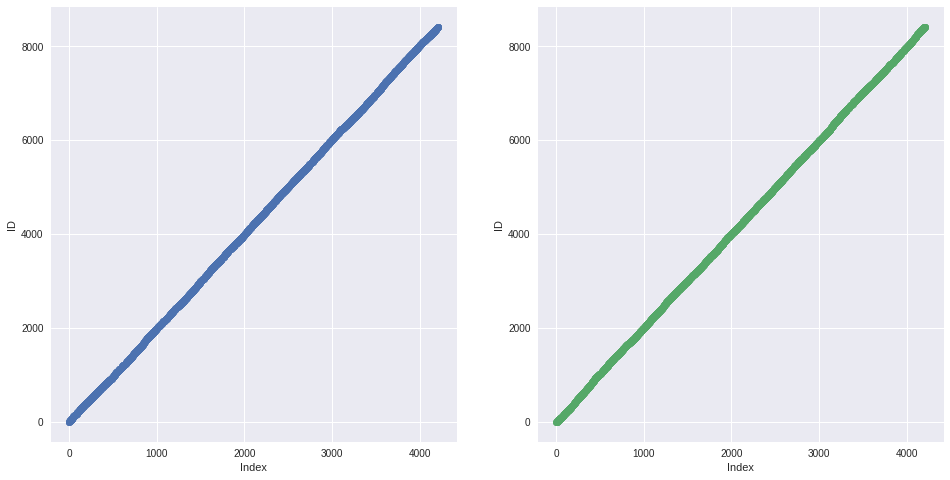

In [31]:
_, ax = plt.subplots(figsize=(16,8), ncols=2)
ax0=sns.regplot(train1.index.values, train1.ID, ax=ax[0], fit_reg=False, label='train')
ax1=sns.regplot(test.index.values, test.ID, ax=ax[1], fit_reg=False, label='test')
_=ax1.set_xlabel('Index')
_=ax0.set_xlabel('Index')


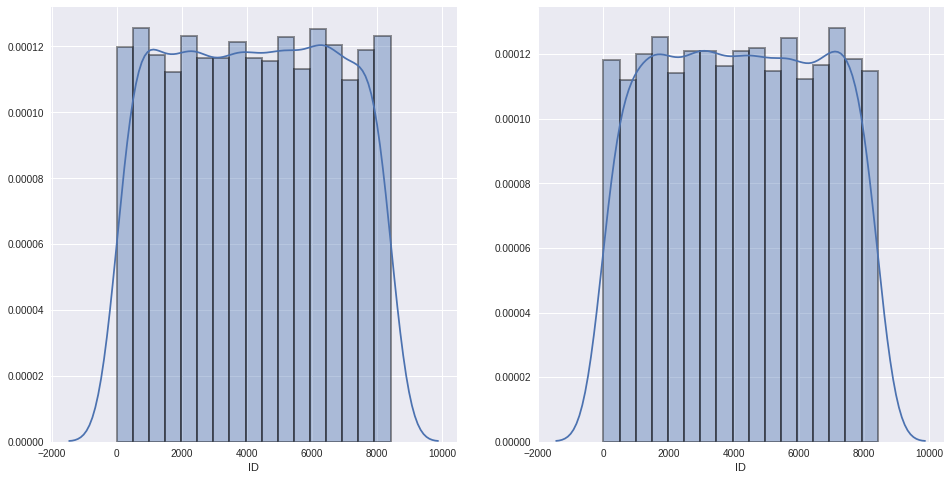

In [32]:
_,ax = plt.subplots(ncols=2, figsize=(16,8))
sns.distplot(train1['ID'], ax=ax[0], hist_kws=dict(edgecolor="k", linewidth=2))
sns.distplot(test['ID'], ax=ax[1], hist_kws=dict(edgecolor="k", linewidth=2))

The above 2 plots try to figure out on what basis test-train split has been made. `ID` feature is a unique ID of each row or each car. `ID` is distributed from 0 to 8417, each of test and train contanis half of them and from the histogram the distribution also looks close to random. 

So now we will try to fit a simple random forest model which could serve as our baseline model. 

### Random Forest

First we need to encode our features in `cat_feat`. We will try both label encoding and one hot encoding and see which gives better score. Also we need not out features in `num_feat` as they are already in binary form. 

In [0]:
# first label encode our cat_feat
encoder = LabelEncoder()
train_le = train1.copy()
test_le = test1.copy()
train_test = pd.concat(( train_le.drop(['y','logy'], axis=1) , test_le), axis=0, ignore_index=True)
for feat in cat_feat : 
    train_test.loc[:,feat] = encoder.fit_transform(train_test[feat])
    
train_le.loc[:,:] = train_test.loc[:train1.shape[0], :]
train_le.loc[:, 'y'] = train1.loc[:, 'y']
train_le.loc[:, 'logy'] = train1.loc[:, 'logy']
test_le = train_test.loc[train1.shape[0]:, :]

In [34]:
train[cat_feat].describe()
test[cat_feat].describe()

,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,47,27,44,7,4,29,12,25
top,z,aa,as,c,d,w,g,j
freq,360,833,1659,1942,4205,231,1042,277


,X0,X1,X2,X3,X4,X5,X6,X8
count,4209,4209,4209,4209,4209,4209,4209,4209
unique,49,27,45,7,4,32,12,25
top,ak,aa,as,c,d,v,g,e
freq,432,826,1658,1900,4203,246,1073,274


As we see in description of `cat_feat` in train and test, we notice that for features `X0`, `X2` and `X5` test has more levels that train. Let's analyse them more. 

In [35]:
exclusive_levels(train1, test1, cat_feat)

Exclusive X0
4 levels in train and not in test : ['q', 'aa', 'ab', 'ac']
6 levels in test and not in train : ['an', 'p', 'ae', 'bb', 'av', 'ag']
Exclusive X1
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X2
5 levels in train and not in test : ['aa', 'o', 'c', 'ar', 'l']
6 levels in test and not in train : ['ad', 'ab', 'w', 'ax', 'u', 'aj']
Exclusive X3
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X4
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X5
1 levels in train and not in test : ['u']
4 levels in test and not in train : ['t', 'a', 'b', 'z']
Exclusive X6
0 levels in train and not in test : []
0 levels in test and not in train : []
Exclusive X8
0 levels in train and not in test : []
0 levels in test and not in train : []


The function `exclusive_levels` prints the levels that are only present in either train or test. The output shows that in `X0`, `X2` and `X5` features have few levels that are only present in train or test. 
1. For the ones present only in train, we can encode them in test by all 0s. 
2. For the ones present only in test, we can delete/remove them as their encoding in train will be all zeros and will not provide any more information to our model while training. Also when our model will meet some of these level/features in test it will have no prior experience of these values and might give unexpected results. 

So for now we will concat train and test, one hot encode the combined dataframe, remove the features that are only present in test and separate them again. 

In [36]:
train_test = pd.concat((train1.drop(['y','logy'], axis=1), test1), axis=0, ignore_index=True)
train_test_ohe = pd.get_dummies(train_test, columns=cat_feat)
features = feat_to_rem(train1, test1, cat_feat)
train_test_ohe = train_test_ohe.drop(features, axis=1)

train_ohe = pd.DataFrame(columns=train_test_ohe.columns)
test_ohe = pd.DataFrame(columns=train_test_ohe.columns)
train_ohe = train_test_ohe[:train1.shape[0]]
train_ohe.loc[:,'y'] = train1['y']
train_ohe.loc[:,'logy'] = train1['logy']
test_ohe = train_test_ohe[train1.shape[0]:]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Function `feat_to_rem()` provides a list of features that should be removed according to the logic made above. 

So now we are ready to train our random forest model. 

In [37]:
Find two non-negative matrices (W, H) whose product approximates the non- negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.

X_le = train_le.drop(['y','logy'], axis=1)
y = train_le['y']
logy = train_le['logy']
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
feat_imp_le = pd.DataFrame(columns=X_le.columns)
for train_index, val_index in tqdm(kf.split(X_le)):
    X_le_train, X_le_val = X_le.iloc[train_index], X_le.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    rf_le = RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=random_state)
    _= rf_le.fit(X_le_train, y_train)
    feat_imp_le.loc[feat_imp_le.shape[0],:] = rf_le.feature_importances_
    predictions_le = []
    for tree in rf_le.estimators_:
        predictions_le.append(tree.predict(X_le_val))
        cum_mean_le = np.cumsum(np.array(predictions_le), axis=0)/np.arange(1, np.array(predictions_le).shape[0]+1)[:,None]


5it [03:39, 43.84s/it]


100%|██████████| 1000/1000 [00:00<00:00, 5964.86it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


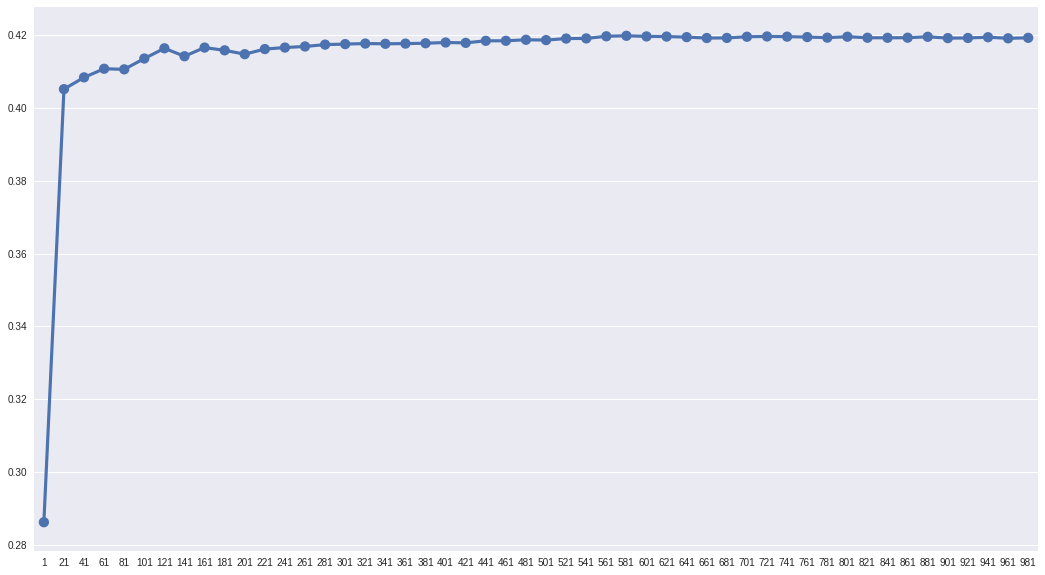

In [38]:
r2_scores_le = []
for y_pred in tqdm(cum_mean_le):
    r2_scores_le.append(r2_score(y_val, y_pred))
sns.set_style('darkgrid')
_,ax = plt.subplots(figsize=(18,10))
sns.pointplot(np.arange(1,cum_mean_le.shape[0]+1,20), [r2_scores_le[i] for i in list(np.arange(1,cum_mean_le.shape[0]+1,20))])

As we can from above plot that around 600 trees are enough for r2_score to flatten. Here we trained a random forest model on label encoded data and got an accuracy of around 0.42 . Notice that I have trained only one random forest with `n_estimators` and calculated the accuracy of all random forest models that will have `n_estimators`< 1000. 

Now let's try our `logy` as target and see if we can improve our score. 

In [39]:
rf = RandomForestRegressor(n_estimators=600, 
                           max_features='sqrt', 
                           random_state=random_state, 
                           n_jobs=-1
                          )
_=rf.fit(X_le.iloc[train_index], logy.iloc[train_index])
pred_log = rf.predict(X_le.iloc[val_index])
print (r2_score(y.iloc[val_index], np.exp(pred_log)))

0.42028803472183907


So log transformation is also of no help. Let's now use our one hot encoded data. 

In [40]:
X_ohe = train_ohe.drop(['y','logy'], axis=1)
y = train_ohe['y']
logy = train_ohe['logy']
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
feat_imp_ohe = pd.DataFrame(columns=X_ohe.columns)
for train_index, val_index in tqdm(kf.split(X_ohe)):
    X_ohe_train, X_ohe_val = X_ohe.iloc[train_index], X_ohe.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    rf_ohe = RandomForestRegressor(n_estimators=500, max_features='sqrt', n_jobs=-1, random_state=random_state)
    _= rf_ohe.fit(X_ohe_train, y_train)
    predictions_ohe = []
    feat_imp_ohe.loc[feat_imp_ohe.shape[0],:] = rf_ohe.feature_importances_
    for tree in rf_ohe.estimators_:
        predictions_ohe.append(tree.predict(X_ohe_val))
        cum_mean_ohe = np.cumsum(np.array(predictions_ohe), axis=0)/np.arange(1, np.array(predictions_ohe).shape[0]+1)[:,None]


5it [01:38, 19.72s/it]


100%|██████████| 500/500 [00:00<00:00, 5938.32it/s]
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


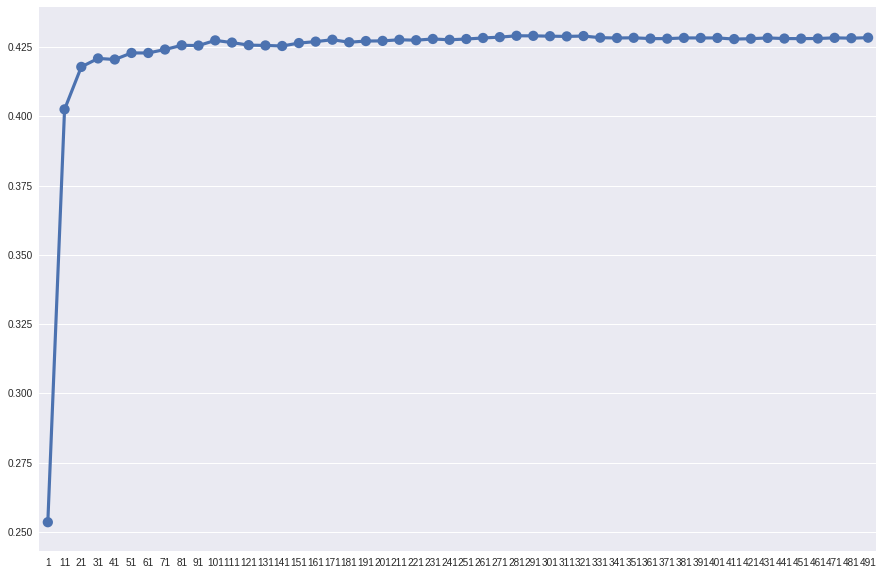

In [41]:
r2_scores_ohe = []
for y_pred in tqdm(cum_mean_ohe):
    r2_scores_ohe.append(r2_score(y_val, y_pred))
sns.set_style('darkgrid')
_,ax = plt.subplots(figsize=(15,10))
sns.pointplot(np.arange(1,cum_mean_ohe.shape[0]+1,10), [r2_scores_ohe[i] for i in list(np.arange(1,cum_mean_ohe.shape[0]+1,10))])

In [42]:
rf = RandomForestRegressor(n_estimators=300, 
                           max_features='sqrt', 
                           random_state=random_state, 
                           n_jobs=-1
                          )
_=rf.fit(X_ohe.iloc[train_index], logy.iloc[train_index])
pred_log = rf.predict(X_ohe.iloc[val_index])
print (r2_score(y.iloc[val_index], np.exp(pred_log)))

0.43080887851842375


So while using one hot encoded features we see small improvement which doesn't change much if we log transform our target variable. The `r2_score` plateaus out at 270-280. 

Next we will figure out feature importances from both encodings and see which features need more attention. 

In [0]:
feat_imp_le = feat_imp_le.mean(axis=0).sort_values()
feat_imp_ohe = feat_imp_ohe.mean(axis=0).sort_values()

In [44]:
feat_imp_ohe.tail()
feat_imp_le.tail()
feat_imp_ohe.head()
feat_imp_le.head()


X313    0.023708
ID      0.051794
X261    0.061968
X314    0.066181
X127    0.066411
dtype: float64

X5      0.045640
X314    0.067214
X261    0.069425
ID      0.071029
X127    0.076490
dtype: float64

X270    7.785918e-07
X0_g    1.069577e-06
X280    1.511589e-06
X42     1.852606e-06
X210    2.203426e-06
dtype: float64

X372    0.000002
X280    0.000003
X257    0.000003
X270    0.000003
X210    0.000003
dtype: float64

So here we have feature importances of model trained on both label encoded data and one hot encoded data. Let's calculate feature importances based on ANOVA and maximum variance(we have done this in `var_df`). We here take values of `logy` instead of `y` as one of the `stats.f_oneway` assumes the values to be from normal data and log transformation makes our target variable `y` close to normal.

In [45]:
feat_imp_anova = anova(X_ohe.columns, 'logy', train_ohe).sort_values(by='p-value')

  0%|          | 0/507 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:2967: RuntimeWarning: divide by zero encountered in true_divide
  msw = sswn / float(dfwn)
100%|██████████| 507/507 [00:21<00:00, 24.04it/s]


Till now we have ranked features based on their variance, statistical significance and random forest models. So now we can analyse more important features and neglect irrelevant ones. So let's end this notebook here and we will continue this in next one. You can use `%store` magic command to store the variables you want to from this notebook so that we can use them in our notebook. 

In [46]:
%store cat_feat
%store num_feat
%store feat_imp_anova
%store feat_imp_le
%store feat_imp_ohe
%store random_state
%store test
%store test1
%store test_le
%store test_ohe
%store train
%store train1
%store train_le
%store train_ohe
%store var_df

Stored 'cat_feat' (Index)
Stored 'num_feat' (Index)
Stored 'feat_imp_anova' (DataFrame)
Stored 'feat_imp_le' (Series)
Stored 'feat_imp_ohe' (Series)
Stored 'random_state' (int)
Stored 'test' (DataFrame)
Stored 'test1' (DataFrame)
Stored 'test_le' (DataFrame)
Stored 'test_ohe' (DataFrame)
Stored 'train' (DataFrame)
Stored 'train1' (DataFrame)
Stored 'train_le' (DataFrame)
Stored 'train_ohe' (DataFrame)
Stored 'var_df' (DataFrame)
